In [156]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display, HTML
from jinja2 import Template

In [157]:
# Define the ticker symbol
tickerSymbol = 'F'

# Define the benchmark yield
bm_tickerSymbol = '^IRX'

# How many times the div is paid per year
timePerYear = 4
dividend_fill_limit = 66 ## trading days 20-ish if dividend is monthly

# Define the number of years prior to the current date
years_prior = 1

# Define fibonocci levels
fib_levels = [-0.236, 0, 0.236, 0.382, 0.5, 0.618, 0.786, 1, 1.236]

In [158]:
def get_summary_report(ticker_symbol):
    try:
        stock = yf.Ticker(ticker_symbol)
        info = stock.info

        summary_report = {
            "Label": info.get("symbol", "N/A"),
            "Exchange": info.get("exchange", "N/A"),
            "Sector": info.get("sector", "N/A"),
            "Industry": info.get("industry", "N/A"),
            "1 Year Target": f"${info.get('targetMeanPrice', 0):.2f}",
            "Today's High/Low": f"${info.get('dayHigh', 0):.2f}/${info.get('dayLow', 0):.2f}",
            "Share Volume": f"{info.get('volume', 0):,.0f}",
            "Average Volume": f"{info.get('averageVolume', 0):,.0f}",
            "Previous Close": f"${info.get('regularMarketPreviousClose', 0):.2f}",
            "52 Week High/Low": f"${info.get('fiftyTwoWeekHigh', 0):.2f}/${info.get('fiftyTwoWeekLow', 0):.2f}",
            "Market Cap": f"${info.get('marketCap', 0):,.0f}",
            "P/E Ratio": f"{info.get('trailingPE', 0):.2f}",
            "Forward P/E 1 Yr.": f"{info.get('forwardPE', 0):.2f}",
            "Earnings Per Share(EPS)": f"${info.get('trailingEps', 0):.2f}",
            "Annualized Dividend": f"${info.get('dividendRate', 0):.2f}",
            "Ex Dividend Date": datetime.fromtimestamp(info.get('exDividendDate', 0)).strftime('%b %d, %Y'),
            "Dividend Pay Date": datetime.fromtimestamp(info.get('lastDividendDate', 0)).strftime('%b %d, %Y'),
            "Current Yield": f"{info['dividendYield']*100:.2f}%" if 'dividendYield' in info and info['dividendYield'] is not None else "N/A",
        }

        return summary_report

    except Exception as e:
        return {"Error": f"Error fetching data for {ticker_symbol}: {e}"}

def generate_html_report(summary_data):
    html_template = '''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Summary Report for {{ summary_data["Label"] }}</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #333;
                color: #fff;
            }
            table {
                border-collapse: collapse;
                width: 50%;
                margin: 20px auto;
            }
            th, td {
                padding: 10px;
                border-bottom: 1px solid #ddd;
            }
            th {
                background-color: #f2f2f2;
                color: #000;
                text-align: right;
            }
            td {
                text-align: left;
            }
            h1 {
                text-align: center;
            }
        </style>
    </head>
    <body>
        <h1>Summary Report for {{ summary_data["Label"] }}</h1>
        <table>
            {% for key, value in summary_data.items() %}
            <tr>
                <th>{{ key }}</th>
                <td>{{ value }}</td>
            </tr>
            {% endfor %}
        </table>
    </body>
    </html>
    '''

    template = Template(html_template)
    return template.render(summary_data=summary_data)

In [159]:
def get_fibonacci_levels(high, low):
    # Fibonacci retracement levels
    diff = high - low
    
    fibonacci_values = [ (high - level * diff) if level >= 0.0 and level <= 1.0 else (low + level * diff) for level in fib_levels]
     
    return fibonacci_values


In [160]:
summary_data = get_summary_report(tickerSymbol)
if 'Error' in summary_data:
    print(summary_data['Error'])
else:
    # Generate the complete HTML report
    html_report = generate_html_report(summary_data)

    # Display the HTML report directly in Jupyter Notebook or IPython
    display(HTML(html_report))

Label,F
Exchange,NYQ
Sector,Consumer Cyclical
Industry,Auto Manufacturers
1 Year Target,$12.85
Today's High/Low,$13.61/$13.02
Share Volume,"97,455,972"
Average Volume,"59,651,016"
Previous Close,$13.73
52 Week High/Low,$16.68/$10.90
Market Cap,"$52,887,379,968"


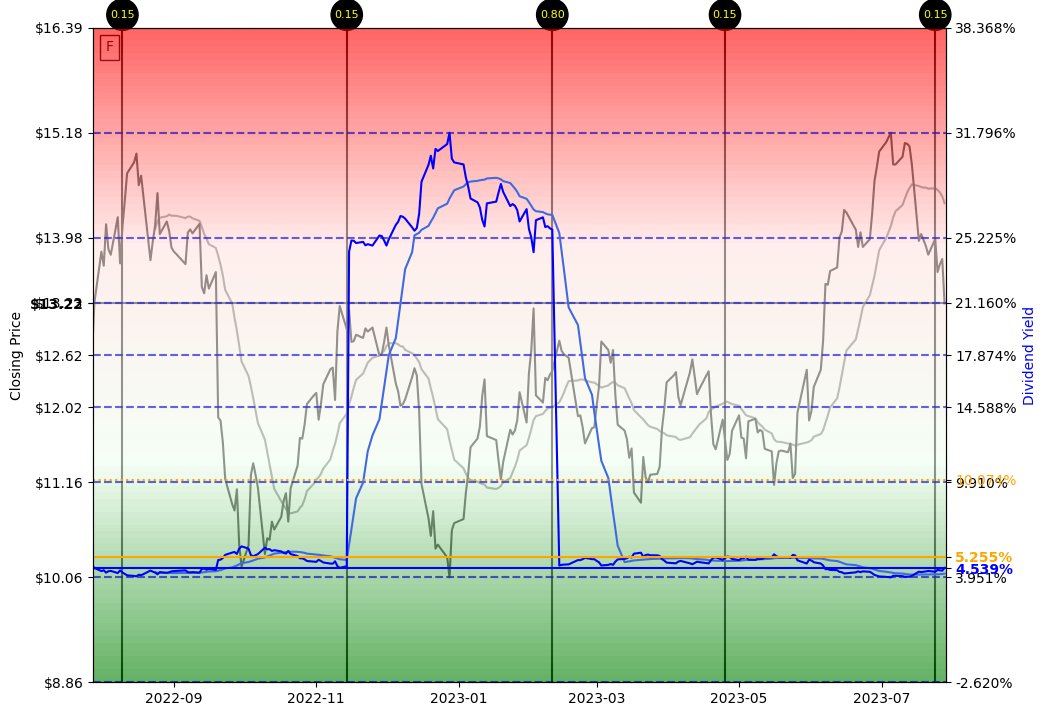

In [161]:
# Calculate the start date
current_date = datetime.today()
start_date = current_date - timedelta(days=365 * years_prior)
start_date_str = start_date.strftime('%Y-%m-%d')

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history( start=start_date_str )
# Get just dividend dataframes
dividendsDf = tickerDf[tickerDf['Dividends'] != 0]

# Calculate the actual dividend yield based on the last dividend payment
# Backfill dividend values that are 0 with the previous non-zero value within the past x rows
tickerDf['Dividends'].replace(0.0, np.nan, inplace=True, limit=dividend_fill_limit)

tickerDf['Dividends'].fillna(method='backfill', limit=dividend_fill_limit, inplace=True)

# forecast the dividend yield based on the last dividend payment
# get the last non-zero value within the last dividend_fill_limit rows
last_non_zero_value = tickerDf['Dividends'].tail(dividend_fill_limit).replace(0.0, np.nan).ffill().iloc[-1]


# fill the column with the last non-zero value within the last 60 rows
tickerDf['Dividends'].tail(dividend_fill_limit).fillna(last_non_zero_value, inplace=True)

# Add a column called dividend_yield that calculates the dividend yield by taking the last dividend payment that is greater than 0 and divides it by the daily closing price
tickerDf['Dividend Yield'] = (tickerDf['Dividends']) / tickerDf['Close'] * 100 * timePerYear

# Get the benchmark rate
bm_tickerData = yf.Ticker(bm_tickerSymbol)
bm_tickerDf = bm_tickerData.history(period='1d')

bm_yield = bm_tickerDf['Close'].iloc[-1]

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(11, 8.5))
ax2 = ax1.twinx()

# Set the labels and colors for the y-axes
ax1.set_ylabel('Closing Price', color='black')

# Plot the data
ax1.plot(tickerDf['Close'].rolling(window=20).mean(), color='dimgray')
ax1.plot(tickerDf['Close'], color='black')

# Set the limits of the x-axis
ax1.set_xlim(start_date, current_date)





# Fibonacci retracement levels (price)
high_price = tickerDf['Close'].max()
low_price = tickerDf['Close'].min()
fibonacci_values_price = get_fibonacci_levels(high_price, low_price)

ax1.set_ylim(min(fibonacci_values_price), max(fibonacci_values_price))

for level, value in zip(fib_levels, fibonacci_values_price):
    ax1.axhline(value, linestyle='--', alpha=0.5, color='black')



from matplotlib.font_manager import FontProperties
bold_font = FontProperties(weight='bold')

# Set ticks and add last closing
last_close = tickerDf['Close'][-1]
last_yield = tickerDf['Dividend Yield'][-1]

y1ticks = fibonacci_values_price + [ last_close]
y1ticklabels = [f'${value:.2f}' for value in y1ticks]
ax1.set_yticks(y1ticks, labels=y1ticklabels)

y1tick_labels = ax1.get_yticklabels()
y1tick_labels[-1].set_font_properties(bold_font)

ax1.axhline(last_close, linestyle='-', color='black')


# Fibonacci retracement levels (yield)
high_yield = max(tickerDf['Dividend Yield'].max(), bm_yield)
low_yield = min(tickerDf['Dividend Yield'].min(), bm_yield)


fibonacci_values_yield = get_fibonacci_levels(high_yield, low_yield)
ax2.set_ylim(min(fibonacci_values_yield), max(fibonacci_values_yield))

for level, value in zip(fib_levels, fibonacci_values_yield):
    ax2.axhline(value, linestyle='--', alpha=0.5, color='blue')
    #ax2.text(start_date, value, f'{level:.2f} ({value:.2f}%)', color='dimgray', va='center')

# Plot the historical yield
ax2.plot(tickerDf['Dividend Yield'].rolling(window=20).mean(), color='royalblue')
ax2.plot(tickerDf['Dividend Yield'], color='blue')

avg_yield = tickerDf['Dividend Yield'].mean()

# Set ticks for the average yield and fib levels
y2ticks = fibonacci_values_yield + [bm_yield, avg_yield, tickerDf['Dividend Yield'][-1]]
y2ticklabels = [f'{value:.3f}%' for value in y2ticks]
ax2.set_yticks(y2ticks, labels=y2ticklabels)
#ax2.text(start_date, avg_yield, f'{avg_yield:.2f}%', color='orange', va='center')

# Plot the Average yield
ax2.axhline(avg_yield, linestyle=':', color='orange')
# Plot the benchmark yield
ax2.axhline(bm_yield, linestyle='-', color='orange')
# Plot the last yield
ax2.axhline(last_yield, linestyle='-', color='blue')

# Set the labels and colors for the y-axes
ax2.set_ylabel('Dividend Yield', color='blue')

# Change the color of the last y-tick label
y2tick_labels = ax2.get_yticklabels()
y2tick_labels[-1].set_color('blue') # Yield based on last closing price
y2tick_labels[-1].set_font_properties(bold_font)
y2tick_labels[-2].set_color('orange') # Average yield
y2tick_labels[-3].set_color('orange') # Benchmark yield
y2tick_labels[-3].set_font_properties(bold_font)

# Create a gradient colormap for the background
colors = ['green','honeydew', 'mistyrose', 'red']
cmap = LinearSegmentedColormap.from_list('gradient', colors)
# Create an array for the gradient background
gradient_data = np.linspace(0, 1, 100).reshape(1, -1)
# Add the gradient background
ax2.imshow(gradient_data.T, aspect='auto', cmap=cmap, extent=[start_date, current_date, max(fibonacci_values_yield), min(fibonacci_values_yield)], alpha=0.6)


# Get the y-axis range
bottom, top = ax1.get_ylim()

# Add text annotations along the top of the chart
for index, row in dividendsDf.iterrows():
    ax1.annotate(f"{row['Dividends']:.2f}", xy=(index, top), xytext=(0, 10), textcoords="offset pixels", annotation_clip=False, ha='center', fontsize=8, bbox=dict(boxstyle='circle', fc='black', ec='black'), color='yellow')
    ax1.axvline(x=index, color='black')

# Add ticker symbol to chart
from matplotlib.offsetbox import AnchoredText
at = AnchoredText(tickerSymbol.capitalize(), loc='upper left', frameon=True)
ax1.add_artist(at)